In [2]:
import pandas as pd
import numpy as np
import nltk
import pyLDAvis.sklearn
from collections import Counter
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from nltk.sentiment import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF
from wordcloud import WordCloud, ImageColorGenerator
import matplotlib.pyplot as plt
import seaborn as sns
import string
%matplotlib inline
pd.options.mode.chained_assignment = None
pd.set_option('display.max_colwidth', 100)

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\cheng\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
c:\Users\cheng\Anaconda3\lib\site-packages\matplotlib\__init__.py:169: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(module.__version__) < minver:
c:\Users\cheng\Anaconda3\lib\site-packages\setuptools\_distutils\version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
c:\Users\cheng\Anaconda3\lib\site-packages\matplotlib\__init__.py:169: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(module.__version__) < minver:
c:\Users\cheng\Anaconda3\lib\site-packages\setuptools\_distutils\version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


In [18]:
# import data
df = pd.read_csv('BCS_processed_critic_reviews.csv')[['top_critic', 'review_icon', 'season', 'review_quote_processed']]
df.head()

,top_critic,review_icon,season,review_quote_processed
0,False,fresh,1,break bad expand universe look equally great well call saul
1,False,fresh,1,know watch foundation amaze building laid would pleasurable finished article
2,False,rotten,1,creator gilligan gould leave entire swathe people-specifically look like them-in dustbin trope s...
3,False,fresh,1,well call saul magnificent job highlight far people can-and will-go `` right ''
4,False,fresh,1,hard imagine break bad spin-off able cap brilliance series thanks superb performance bob odenkir...


# 1. Sentiment Analysis : How do people like this TV show?

In [19]:
#sentiment analysis
sia = SentimentIntensityAnalyzer()
df['sentiment'] = df['review_quote_processed'].apply(lambda x: sia.polarity_scores(x)['compound'])

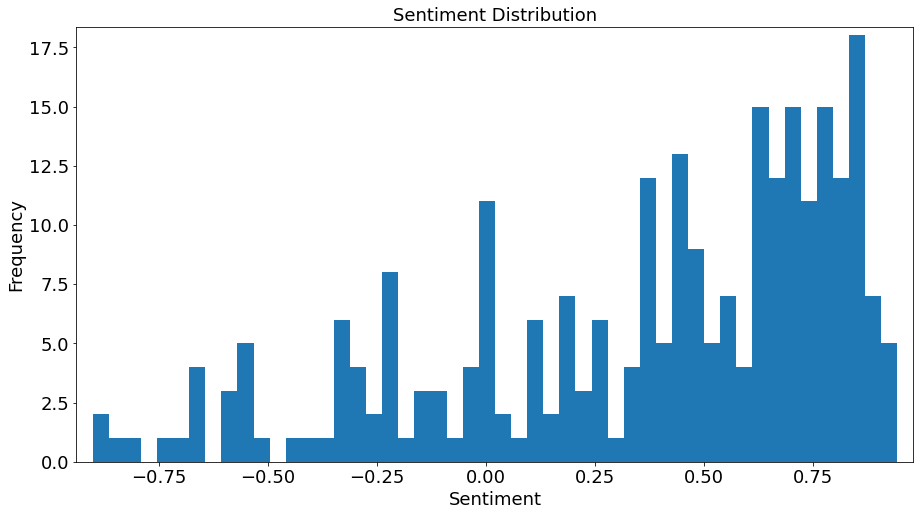

In [20]:
#histogram of sentiment scores
plt.figure(figsize=(15, 8))
plt.margins(0.02)
plt.xlabel('Sentiment', fontsize=18)
plt.xticks(fontsize=18)
plt.ylabel('Frequency', fontsize=18)
plt.yticks(fontsize=18)
plt.hist(df['sentiment'], bins=50)
plt.title('Sentiment Distribution', fontsize=18)
plt.show()

c:\Users\cheng\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


(array([0, 1]), [Text(0, 0, 'fresh'), Text(1, 0, 'rotten')])

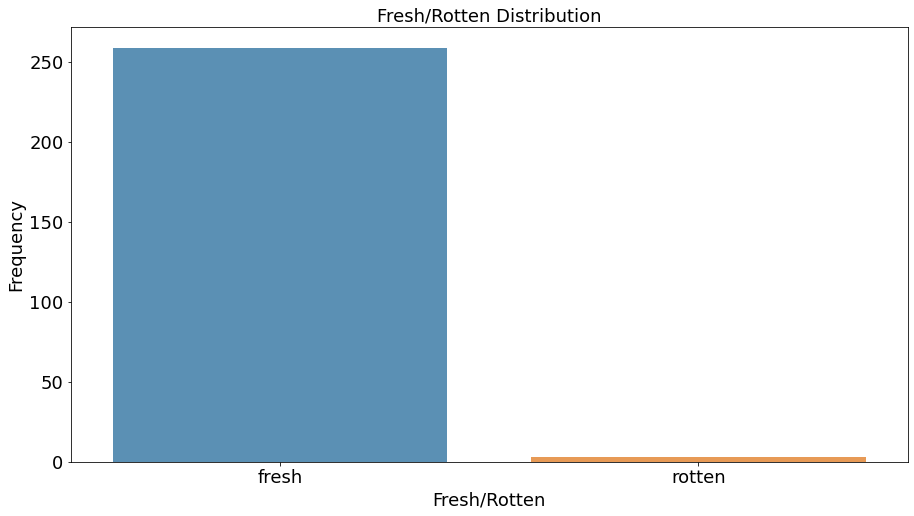

In [21]:
x_rating = df.review_icon.value_counts()
plt.figure(figsize=(15,8))
sns.barplot(x_rating.index, x_rating.values, alpha=0.8)
plt.title("Fresh/Rotten Distribution", fontsize=18)
plt.ylabel('Frequency', fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel('Fresh/Rotten', fontsize=18)
plt.xticks(fontsize=18)

<AxesSubplot:title={'center':'Percentage of Fresh/Rotten'}, ylabel='review_icon'>

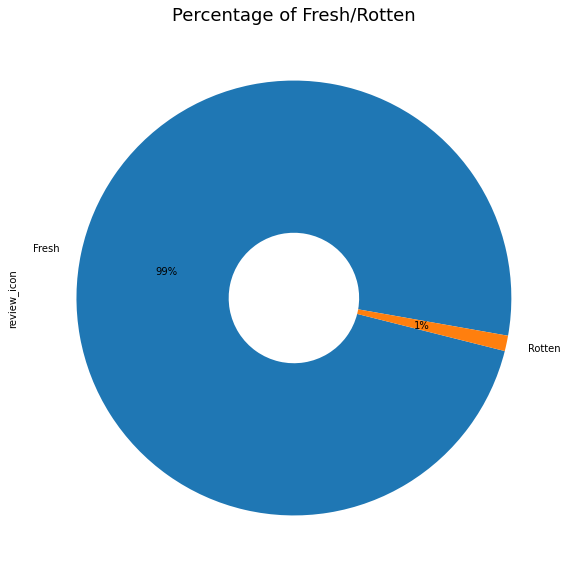

In [22]:
# pie chart
plt.figure(figsize=(20,10))
plt.title('Percentage of Fresh/Rotten', fontsize=18)
df.review_icon.value_counts().sort_index().plot(kind='pie', labels=['Fresh', 'Rotten'],
                              wedgeprops=dict(width=.7), autopct='%1.0f%%', startangle= -10, 
                              textprops={'fontsize':10})

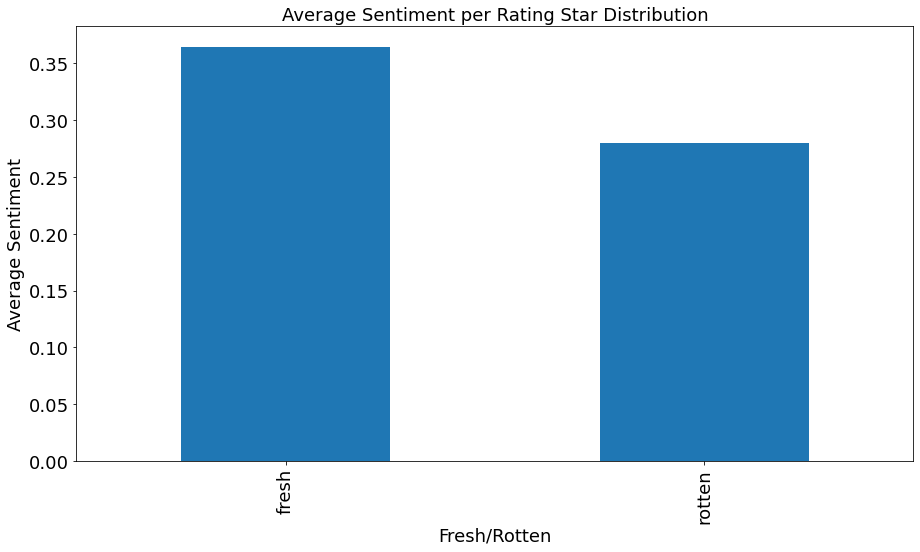

In [23]:
polarity_avg = df.groupby('review_icon')['sentiment'].mean().plot(kind='bar', figsize=(15,8))
plt.xlabel('Fresh/Rotten', fontsize=18)
plt.ylabel('Average Sentiment', fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.title('Average Sentiment per Rating Star Distribution', fontsize=18)
plt.show()

**Sentiment analysis is the process of determining the reviewer's attitude or opinion ranging from -1 (negative attitude) to 1 (positive attitude). After drawing a histogram of our sentiment, we can see that the vast majority of our derived sentiment scores is overwhelmingly positive. When we compare this against *Fresh/Rotten*, we can see a similar pattern emerge. The majority of critics gave *Fresh* to Better Call Saul. Not only do we feel confortable in the accuracy of the sentiment analysis but we can see that overall review attitude about the show is very positive.**

# 2. Term Frequency Analysis

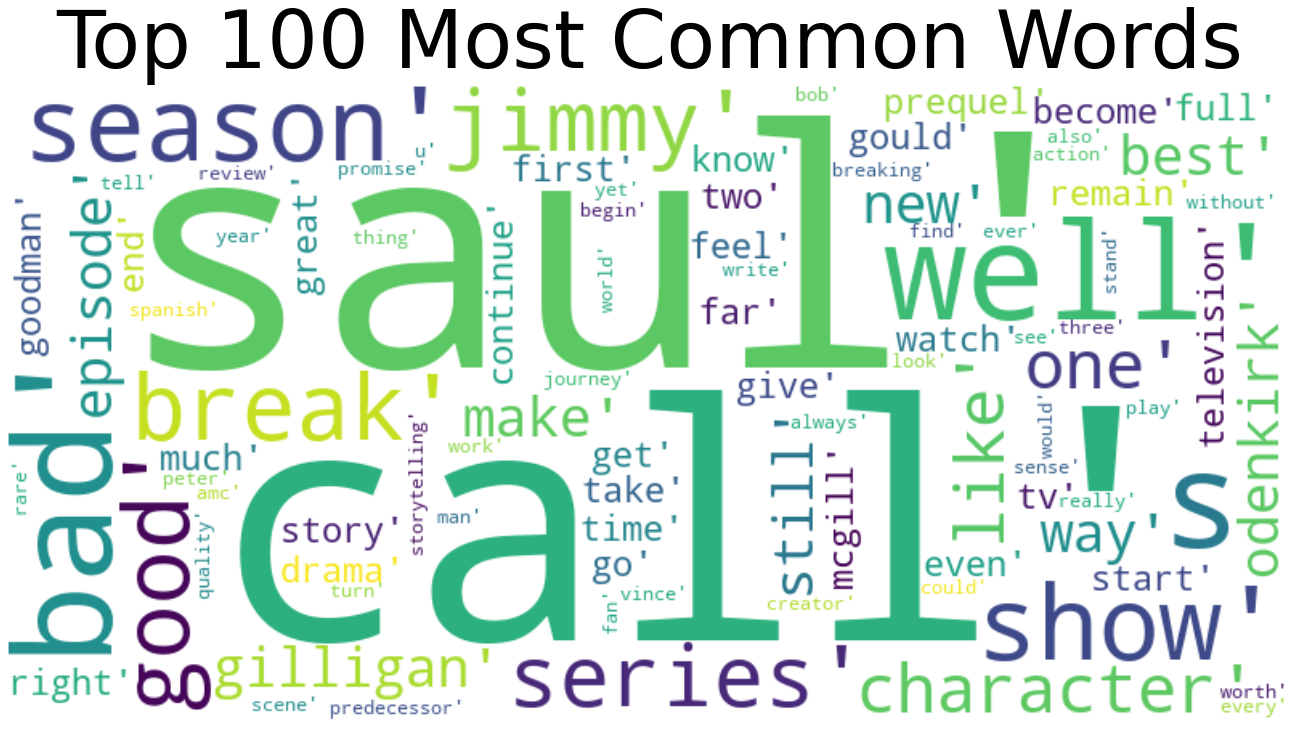

In [24]:
words = df['review_quote_processed'].apply(lambda x: x.split())
allwords = []
for wordlist in words:
    allwords += wordlist

mostcommon = FreqDist(allwords).most_common(100)
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(str(mostcommon))

fig = plt.figure(figsize=(30,10), facecolor='white')
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Top 100 Most Common Words', fontsize=80)
plt.tight_layout(pad=0)
plt.show()

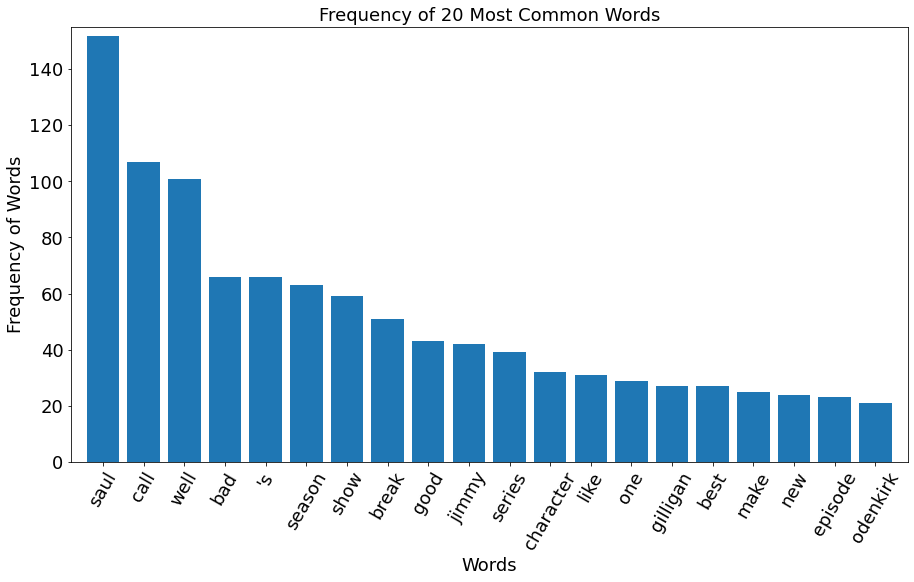

In [26]:
mostcommon_small = FreqDist(allwords).most_common(20)
x, y = zip(*mostcommon_small)
plt.figure(figsize=(15,8))
plt.margins(0.02)
plt.bar(x, y)
plt.xlabel('Words', fontsize=18)
plt.ylabel('Frequency of Words', fontsize=18)
plt.yticks(fontsize=18)
plt.xticks(rotation=60, fontsize=18)
plt.title('Frequency of 20 Most Common Words', fontsize=18)
plt.show()

**The results of the term frequency analysis certainly supports the overall positive sentiment of the reviews. Terms such as *best*, *character*, *like* show that critics enjoy the show.**

**Same as in the analysis of audience review, we also find that critics mention a lot about the TV show Breaking Bad. The high frequency of terms such as *break*, *bad* show that people tend to compare this show with Breaking Bad in their reviews.**

# 4. Topic Modeling

In [31]:
tf_vectorizer = CountVectorizer(max_df=0.9, min_df=25, max_features=5000)
tf = tf_vectorizer.fit_transform(df['review_quote_processed'].values.astype('U'))
tf_feature_names = tf_vectorizer.get_feature_names()
doc_term_matrix = pd.DataFrame(tf.toarray(), columns=list(tf_feature_names))
doc_term_matrix

c:\Users\cheng\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,bad,best,break,call,character,gilligan,good,jimmy,like,one,saul,season,series,show,well
0,1,0,1,1,0,0,0,0,0,0,1,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1
4,1,0,1,0,0,0,1,0,0,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
257,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
258,0,0,0,1,0,0,0,0,0,0,1,0,1,1,4
259,0,1,0,0,1,0,0,1,0,1,1,0,0,0,0
260,0,0,0,1,0,0,0,1,0,0,1,1,0,0,1


In [32]:
lda_model = LatentDirichletAllocation(n_components=5, learning_method='online', max_iter=500, random_state=0).fit(tf)
no_top_words = 10
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i]
                          for i in topic.argsort()[:-no_top_words - 1:-1]]))
              
display_topics(lda_model, tf_feature_names, no_top_words)

Topic 0:
well saul call bad break season series show jimmy one
Topic 1:
jimmy one best saul character series season bad break show
Topic 2:
show like break bad well saul call jimmy series gilligan
Topic 3:
good saul call series best season one bad break character
Topic 4:
season character gilligan bad break series saul good jimmy call


**We use the Latent Dirichlet Allocation (LDA) approach to determine 5 topics in our corpus and each topic consists of 10 words.**

**It certainly takes a little imagination to understand the topics produced by the LDA model.** 

**When we look at these topics, it seems that they all convey similar messages: Better Call Saul is a great prequel to Breaking Bad. Jimmy is good character created by Gilligan.**

In [33]:
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(lda_model, tf, tf_vectorizer, mds='tsne')
panel

c:\Users\cheng\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
c:\Users\cheng\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(
c:\Users\cheng\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\cheng\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
c:\Users\cheng\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:819: FutureWarning: 's

PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
0      150.222153  -72.269554       1        1  46.082102
3       51.163364 -159.968018       2        1  17.357387
4      -73.144554   21.523815       3        1  13.233452
1      -66.410133 -110.606438       4        1  12.865244
2       54.417324   12.443444       5        1  10.461815, topic_info=      Term        Freq       Total Category  logprob  loglift
13    show   80.000000   80.000000  Default  15.0000  15.0000
11  season   67.000000   67.000000  Default  14.0000  14.0000
14    well  118.000000  118.000000  Default  13.0000  13.0000
6     good   43.000000   43.000000  Default  12.0000  12.0000
7    jimmy   46.000000   46.000000  Default  11.0000  11.0000
..     ...         ...         ...      ...      ...      ...
7    jimmy    0.269162   46.592931   Topic5  -5.8338  -2.8965
11  season    0.267909   67.677916   Topic5  -5.8385  -3.2744
3     call    0.269237  105.253998   Topic5  -5.8335  -3.7111
14    well    0.269630  118.022801   Topic5  -5.8321  -3.8241
10    saul    0.269621  139.214022   Topic5  -5.8321  -3.9893

[90 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
0         1  0.711411        bad
0         3  0.266779        bad
1         2  0.387896       best
1         4  0.596763       best
2         1  0.971121      break
3         1  0.646056       call
3         2  0.342030       call
4         3  0.640366  character
4         4  0.353306  character
5         3  0.968872   gilligan
6         2  0.970422       good
7         1  0.364862      jimmy
7         4  0.622412      jimmy
8         5  0.961320       like
9         4  0.955784        one
10        1  0.553105       saul
10        2  0.294511       saul
10        4  0.143664       saul
11        1  0.354621     season
11        3  0.635362     season
12        1  0.488252     series
12        2  0.488252     series
13        1  0.237131       show
13        5  0.748835       show
14        1  0.991334       well, R=15, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 4, 5, 2, 3])

**We also use pyLADvis to visualze how similar the topics are to each other and top-30 most relevant words for each topic.**

# 5. Which season do critics like the most?

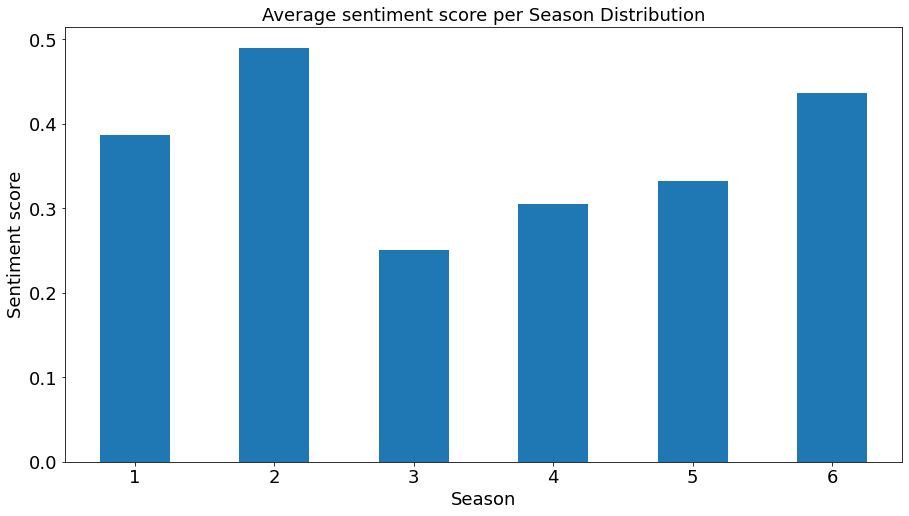

In [34]:
star_avg = df.groupby('season')['sentiment'].mean().plot(kind='bar', figsize=(15,8))
plt.xlabel('Season', fontsize=18)
plt.ylabel('Sentiment score', fontsize=18)
plt.xticks(rotation = 0, fontsize=18)
plt.yticks(fontsize=18)
plt.title('Average sentiment score per Season Distribution', fontsize=18)
plt.show()

**Critics love the first two seasons the most. They are quite disappointed with season 3. However, it shows that from season 4, Better Call Saul is gaining more positive reviews among critics agin.**